In [4]:
import pandas as pd
import numpy as np
import recordlinkage
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import boxcox, shapiro
import scipy.stats as stats
import usaddress

In [5]:
# business_location = pd.read_parquet("business_locations.parquet")
# raw_finance = pd.read_parquet("raw_financials.parquet")

raw_finance = pd.read_parquet('s3://centercheck-shared-data-science-technical-test/raw_financials.parquet', storage_options={"anon": True})
business_location = pd.read_parquet('s3://centercheck-shared-data-science-technical-test/business_locations.parquet', storage_options={"anon": True})

In [6]:
def parse_address(address):
    try:
        address.lower().strip() # Normalize all address in lowercase and remove unecessary spaces.
        parsed = usaddress.tag(address)[0]  # Used to return a dict with the address components.
        return parsed
    except usaddress.RepeatedLabelError as e:
        return None

# Running the parse_address function for each address.
raw_finance['parsed_address'] = raw_finance['address'].apply(parse_address)
business_location['parsed_street_address'] = business_location['street_address'].apply(parse_address)

# Function to retrive the parsed information.
def extract_component(parsed, component):
    return parsed.get(component, '')

raw_finance['street_name'] = raw_finance['parsed_address'].apply(lambda x: extract_component(x, 'StreetName'))
raw_finance['street_type'] = raw_finance['parsed_address'].apply(lambda x: extract_component(x, 'StreetNamePostType'))
raw_finance['house_number'] = raw_finance['parsed_address'].apply(lambda x: extract_component(x, 'AddressNumber'))

business_location['street_name'] = business_location['parsed_street_address'].apply(lambda x: extract_component(x, 'StreetName'))
business_location['street_type'] = business_location['parsed_street_address'].apply(lambda x: extract_component(x, 'StreetNamePostType'))
business_location['house_number'] = business_location['parsed_street_address'].apply(lambda x: extract_component(x, 'AddressNumber'))

# Using City, postal_code and house_number as a blocking to the recordLinkage function. This was chosen due for being the same informations in both tables and is good to avoid unecessary comparations.
indexer = recordlinkage.Index()
indexer.block(['city', 'postal_code', 'house_number'])
candidate_links = indexer.index(raw_finance, business_location) #Generate the pairs candidates to be similar

compare = recordlinkage.Compare()
compare.exact('city', 'city') #Apply 1 when the cities are equals and 0 if is not.
compare.exact('postal_code', 'postal_code') #Apply 1 when the postal codes are equals and 0 if is not.
#Compare the street names using the jarowinkler, this method compare the similarity between the strings, using a thresold of 95, as higher is the similarity, higher is the score applied. 
compare.string('street_name', 'street_name', method='jarowinkler', threshold=0.95) 
compare.exact('house_number', 'house_number')#Apply 1 when the cities are equals and 0 if is not.

features = compare.compute(candidate_links, raw_finance, business_location) #Here the functions returns a similatiry matrix, telling us with score each feature has.
features.columns = ['city_exact', 'postal_code_exact', 'street_name_similarity', 'house_number_exact']


In [7]:
#Created a general score summing all features score and filtered as a match only is is higher or equal 3, creating a index tables, refering wich index from each table is a match.
features['score'] = features[['city_exact', 'postal_code_exact', 'street_name_similarity', 'house_number_exact']].sum(axis=1)
matched = features[features['score'] >= 3]
matched

city_exact  postal_code_exact  street_name_similarity  \
126     140004           1                  1                     0.0   
127     140004           1                  1                     0.0   
128     140004           1                  1                     0.0   
129     140004           1                  1                     0.0   
130     140004           1                  1                     0.0   
...                    ...                ...                     ...   
4825367 9999             1                  1                     0.0   
4825368 9999             1                  1                     0.0   
4825369 9999             1                  1                     0.0   
4825370 9999             1                  1                     0.0   
4825371 9999             1                  1                     0.0   

                house_number_exact  score  
126     140004                   1    3.0  
127     140004                   1    3.0  
128     140004                   1    3.0  
129     140004                   1    3.0  
130     140004                   1    3.0  
...                            ...    ...  
4825367 9999                     1    3.0  
4825368 9999                     1    3.0  
4825369 9999                     1    3.0  
4825370 9999                     1    3.0  
4825371 9999                     1    3.0  

[3194026 rows x 5 columns]

In [8]:
#Retrieving the indexes and merging tables.
matched_indices = matched.index
finance_indices = matched.index.get_level_values(0)
business_indices = matched.index.get_level_values(1)

finance_matched = raw_finance.loc[finance_indices].reset_index()
business_matched = business_location.loc[business_indices].reset_index()
matched_records = pd.merge(finance_matched, business_matched, left_index=True, right_index=True)

In [9]:
#Visual check on names
matched_records['name_compare'] = matched_records['name_x'] +' // '+ matched_records['name_y']
names_unique = matched_records['name_compare'].unique()
for name in names_unique:
    print(name)

Marco'S Pizza // MARCO'S PIZZA
MARCO'S PIZZA // MARCO'S PIZZA
Staples // STAPLES
STAPLES // STAPLES
STAPLES PRINT MARKETING SERVICES // STAPLES PRINT MARKETING SERVICES
Staples Print Marketing Services // STAPLES PRINT MARKETING SERVICES
Conocophillips // CONOCOPHILLIPS
CONOCOPHILLIPS // CONOCOPHILLIPS
Conoco // CONOCO
CONOCO // CONOCO
Office Depot // OFFICE DEPOT
Office Depot Tech Services // OFFICE DEPOT TECH SERVICES
OFFICE DEPOT TECH SERVICES // OFFICE DEPOT TECH SERVICES
OFFICE DEPOT // OFFICE DEPOT
DISCOUNT TIRE // DISCOUNT TIRE
Discount Tire // DISCOUNT TIRE
HOBBY LOBBY STORES INC // HOBBY LOBBY STORES INC
Hobby Lobby Stores Inc // HOBBY LOBBY STORES INC
Hobby Lobby // HOBBY LOBBY
HOBBY LOBBY // HOBBY LOBBY
Marshalls Inc // MARSHALLS INC
MARSHALLS // MARSHALLS
MARSHALLS INC // MARSHALLS INC
Marshalls // MARSHALLS
Marshalls M0468 // MARSHALLS M0468
MARSHALLS M0468 // MARSHALLS M0468
LOVESAC IN BEST BUY WINTER GARDEN // LOVESAC IN BEST BUY WINTER GARDEN
Best Buy // BEST BUY
BEST B

In [10]:
#Visual check on addresses
matched_records['address_compare'] = matched_records['address'] +' // '+ matched_records['street_address']
address_unique = matched_records['address_compare'].unique()
for address in address_unique:
    print(address)

707 nelson groves suite 640 // 707 Nelson Groves Suite 640
9700 kelly expwy. apt. 203 // 9700 Kelly Expressway Apt. 203
8243 tiffany ferry suite 362 // 8243 Tiffany Ferry Suite 362
7450 LEE MOTORWY. // 7450 Lee Motorway
249 PROCTOR LODGE APT. 885 // 249 Proctor Lodge Apt. 885
568 young village suite 399 // 568 Young Village Suite 399
75011 ANTHONY GTWY. // 75011 Anthony Gateway
2544 willis keys suite 557 // 2544 Willis Keys Suite 557
8606 melanie dr. // 8606 Melanie Drive
8224 hicks falls apt. 573 // 8224 Hicks Falls Apt. 573
5599 White Green Apt. 935 // 5599 White Green Apt. 935
9491 erik land suite 687 // 9491 Erik Land Suite 687
7108 CHRISTOPHER UNIONS SUITE 754 // 7108 Christopher Unions Suite 754
8386 gordon cir. apt. 617 // 8386 Gordon Circle Apt. 617
6777 Ruiz Rd. Suite 789 // 6777 Ruiz Road Suite 789
58090 Wesley Jct. // 58090 Wesley Junction
089 Loretta Wy.S // 089 Loretta Ways
20581 jessica estate suite 197 // 20581 Jessica Estate Suite 197
8586 jenkins pkwy. // 8586 Jenkins 

In [11]:
matched_records['date'] = pd.to_datetime(matched_records['start_at'])
financials = matched_records[['business_entity_id','id_x','id_y','name_y','address','city_x','state_x','postal_code_x','area_sq_ft','date','revenue' ]]
financials.rename(columns={'id_x':'id_finance','id_y':'id_buss_loc','name_y':'business_name','city_x':'city','state_x':'state','postal_code_x':'postal_code'},inplace=True)
financials

C:\Users\lucas\AppData\Local\Temp\ipykernel_42264\2627215402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials.rename(columns={'id_x':'id_finance','id_y':'id_buss_loc','name_y':'business_name','city_x':'city','state_x':'state','postal_code_x':'postal_code'},inplace=True)


business_entity_id  \
0        23e2fcb4-72d8-467d-894a-05e430b187ef   
1        23e2fcb4-72d8-467d-894a-05e430b187ef   
2        23e2fcb4-72d8-467d-894a-05e430b187ef   
3        23e2fcb4-72d8-467d-894a-05e430b187ef   
4        23e2fcb4-72d8-467d-894a-05e430b187ef   
...                                       ...   
3194021  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194022  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194023  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194024  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194025  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   

                                   id_finance  \
0        9355a5d0-f886-4e54-9922-143e62ad2f92   
1        0cb03eef-bcf7-480f-906a-c1e4b5e47ccf   
2        5a52a8cc-f01a-4c14-9f1b-2f02dafc6fc2   
3        cb39c4f2-00cc-4966-85ec-670b3a30e5f0   
4        db67565d-f6d9-49b9-b4a8-868eb2ed0878   
...                                       ...   
3194021  95711560-7cbb-4120-88a6-943363a84fb2   
3194022  81b3fd90-b8a0-4bb5-b369-c7f5e2533be6   
3194023  cf6561a5-fabb-4d2a-ace6-63f7a0a081f0   
3194024  921360e8-b1e2-4fba-a127-ad615f2acd68   
3194025  bec591a4-0ee6-4db0-92ab-9fd0bccdf8cc   

                                  id_buss_loc  business_name  \
0        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
1        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
2        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
3        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
4        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
...                                       ...            ...   
3194021  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194022  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194023  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194024  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194025  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   

                             address           city state postal_code  \
0        707 nelson groves suite 640  North Liberty    IA       74451   
1        707 nelson groves suite 640  North Liberty    IA       74451   
2        707 nelson groves suite 640  North Liberty    IA       74451   
3        707 nelson groves suite 640  North Liberty    IA       74451   
4        707 nelson groves suite 640  North Liberty    IA       74451   
...                              ...            ...   ...         ...   
3194021              922 renee mtn.s      Mira Loma    CA       35039   
3194022              922 renee mtn.s      Mira Loma    CA       35039   
3194023              922 renee mtn.s      Mira Loma    CA       35039   
3194024              922 renee mtn.s      Mira Loma    CA       35039   
3194025              922 renee mtn.s      Mira Loma    CA       35039   

         area_sq_ft       date   revenue  
0              8340 2022-02-01   4029.95  
1              8340 2022-03-01   3125.24  
2              8340 2022-04-01   5500.58  
3              8340 2022-05-01   7346.03  
4              8340 2022-06-01   5993.12  
...             ...        ...       ...  
3194021        7317 2024-06-01  60669.72  
3194022        7317 2024-07-01  59351.03  
3194023        7317 2024-08-01  59253.83  
3194024        7317 2024-09-01  74803.58  
3194025        7317 2024-11-01  73165.60  

[3194026 rows x 11 columns]

In [ ]:
# Assuming a fixed multiplier of 1.25, considering that this raw revenue reflects something like 80% of the total revenue.  
mean_multiplier = 1.25  
std_dev = 0.1  # Applying a small variation to be used. 

# Generating random multipliers using a normal distribution
financials['base_multiplier'] = np.random.normal(loc=mean_multiplier, scale=std_dev, size=len(financials))

# Considering the store size for adjust the multiplier following the ideia of, small business could have a higher card usage % and the base could reflect higher than 80% of the revenue, the opposite could
# happen to big stores, once big stores ussualy could have differents payment ways.
financials['size_adjustment'] = 1 + (0.1 * np.exp(-financials['area_sq_ft'] / 10000)) 

# Creating the initial multiplier before transformation
financials['pre_boxcox_multiplier'] = financials['base_multiplier'] * financials['size_adjustment']

# Applying Box-Cox transformation to get get a normal distribution of the multiplier
financials['boxcox_multiplier'], lambda_value = stats.boxcox(financials['pre_boxcox_multiplier'])
financials['boxcox_multiplier'] = financials['boxcox_multiplier'] + 1


# Generating the adjusted revenue based on this new multiplier.
financials['adjusted_revenue'] = (financials['revenue'] * financials['boxcox_multiplier']).round(2)
financials['boxcox_lambda'] = lambda_value #Store lambda only if is necessary later
financials

C:\Users\lucas\AppData\Local\Temp\ipykernel_41216\3190648022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials['base_multiplier'] = np.random.normal(loc=mean_multiplier, scale=std_dev, size=len(financials))
C:\Users\lucas\AppData\Local\Temp\ipykernel_41216\3190648022.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials['size_adjustment'] = 1 + (0.1 * np.exp(-financials['area_sq_ft'] / 10000))
C:\Users\lucas\AppData\Local\Temp\ipykernel_41216\3190648022.py:13: SettingWithCopyWarning: 

business_entity_id  \
0        23e2fcb4-72d8-467d-894a-05e430b187ef   
1        23e2fcb4-72d8-467d-894a-05e430b187ef   
2        23e2fcb4-72d8-467d-894a-05e430b187ef   
3        23e2fcb4-72d8-467d-894a-05e430b187ef   
4        23e2fcb4-72d8-467d-894a-05e430b187ef   
...                                       ...   
3194021  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194022  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194023  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194024  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   
3194025  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3   

                                   id_finance  \
0        9355a5d0-f886-4e54-9922-143e62ad2f92   
1        0cb03eef-bcf7-480f-906a-c1e4b5e47ccf   
2        5a52a8cc-f01a-4c14-9f1b-2f02dafc6fc2   
3        cb39c4f2-00cc-4966-85ec-670b3a30e5f0   
4        db67565d-f6d9-49b9-b4a8-868eb2ed0878   
...                                       ...   
3194021  95711560-7cbb-4120-88a6-943363a84fb2   
3194022  81b3fd90-b8a0-4bb5-b369-c7f5e2533be6   
3194023  cf6561a5-fabb-4d2a-ace6-63f7a0a081f0   
3194024  921360e8-b1e2-4fba-a127-ad615f2acd68   
3194025  bec591a4-0ee6-4db0-92ab-9fd0bccdf8cc   

                                  id_buss_loc  business_name  \
0        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
1        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
2        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
3        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
4        76b8690f-75f0-4124-9531-65721fdeb8dd  MARCO'S PIZZA   
...                                       ...            ...   
3194021  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194022  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194023  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194024  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   
3194025  08662496-4191-4dbe-b096-14ebd2a9379b          SHELL   

                             address           city state postal_code  \
0        707 nelson groves suite 640  North Liberty    IA       74451   
1        707 nelson groves suite 640  North Liberty    IA       74451   
2        707 nelson groves suite 640  North Liberty    IA       74451   
3        707 nelson groves suite 640  North Liberty    IA       74451   
4        707 nelson groves suite 640  North Liberty    IA       74451   
...                              ...            ...   ...         ...   
3194021              922 renee mtn.s      Mira Loma    CA       35039   
3194022              922 renee mtn.s      Mira Loma    CA       35039   
3194023              922 renee mtn.s      Mira Loma    CA       35039   
3194024              922 renee mtn.s      Mira Loma    CA       35039   
3194025              922 renee mtn.s      Mira Loma    CA       35039   

         area_sq_ft       date   revenue  base_multiplier  size_adjustment  \
0              8340 2022-02-01   4029.95         0.961568         1.043431   
1              8340 2022-03-01   3125.24         1.184163         1.043431   
2              8340 2022-04-01   5500.58         1.169234         1.043431   
3              8340 2022-05-01   7346.03         1.069726         1.043431   
4              8340 2022-06-01   5993.12         1.149384         1.043431   
...             ...        ...       ...              ...              ...   
3194021        7317 2024-06-01  60669.72         1.355222         1.048109   
3194022        7317 2024-07-01  59351.03         1.265998         1.048109   
3194023        7317 2024-08-01  59253.83         1.313429         1.048109   
3194024        7317 2024-09-01  74803.58         1.293272         1.048109   
3194025        7317 2024-11-01  73165.60         1.311711         1.048109   

         pre_boxcox_multiplier  boxcox_multiplier  adjusted_revenue  \
0                     1.003330           1.003329           4043.37   
1                     1.235592           1.233427           3854.75   
2                     1.220014           1.218117    

Validating the multipliers approach

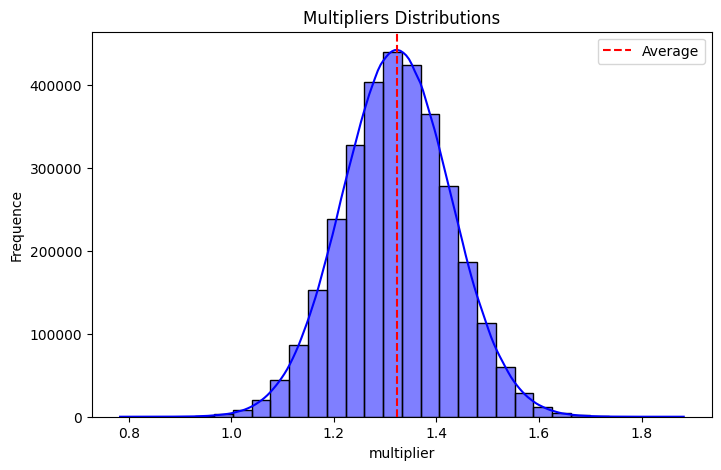

Shapiro-Wilk Test: Statistic=1.0000, p-value=1.0000
Values show a normal distribution!


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 3194026.
  res = hypotest_fun_out(*samples, **kwds)


In [88]:
plt.figure(figsize=(8,5))
sns.histplot(financials['boxcox_multiplier'], bins=30, kde=True, color='blue')
plt.axvline(financials['boxcox_multiplier'].mean(), color='red', linestyle='dashed', label='Average')
plt.title("Multipliers Distributions")
plt.xlabel("multiplier")
plt.ylabel("Frequence")
plt.legend()
plt.show()

# Shapiro-Wilk Normality Test
stat, p_value = shapiro(financials['boxcox_multiplier'])

print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("Values show a normal distribution!")
else:
    print("The values doesn't show a normal distribution!")


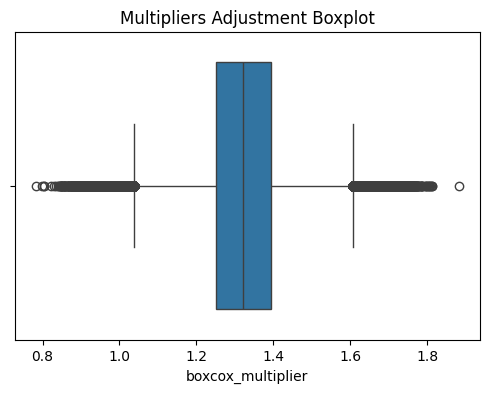

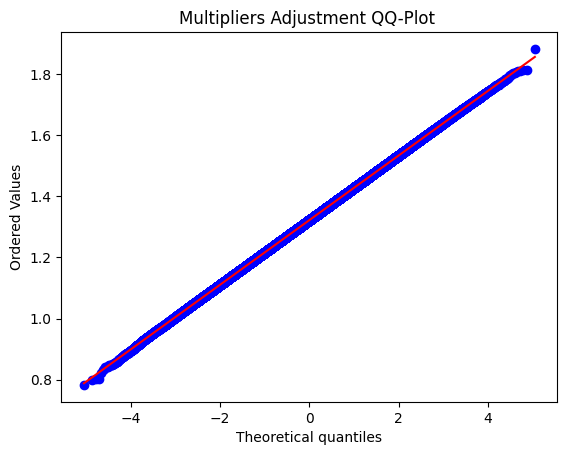

In [89]:
plt.figure(figsize=(6,4))
sns.boxplot(x=financials['boxcox_multiplier'])
plt.title("Multipliers Adjustment Boxplot")
plt.show()

stats.probplot(financials['boxcox_multiplier'], dist="norm", plot=plt)
plt.title("Multipliers Adjustment QQ-Plot ")
plt.show()


In [91]:
#Generating the .parquet and the .csv files of Financials table.
financials.to_parquet('financials.parquet')
financials.to_csv('financials.csv')

As we can see below, the adjustment brings the total Revenue about 1.000.000.000 up over the years.

C:\Users\lucas\AppData\Local\Temp\ipykernel_41216\4043604137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials['month'] = financials['date'].dt.month
C:\Users\lucas\AppData\Local\Temp\ipykernel_41216\4043604137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials['month_txt'] = financials['date'].dt.month_name()


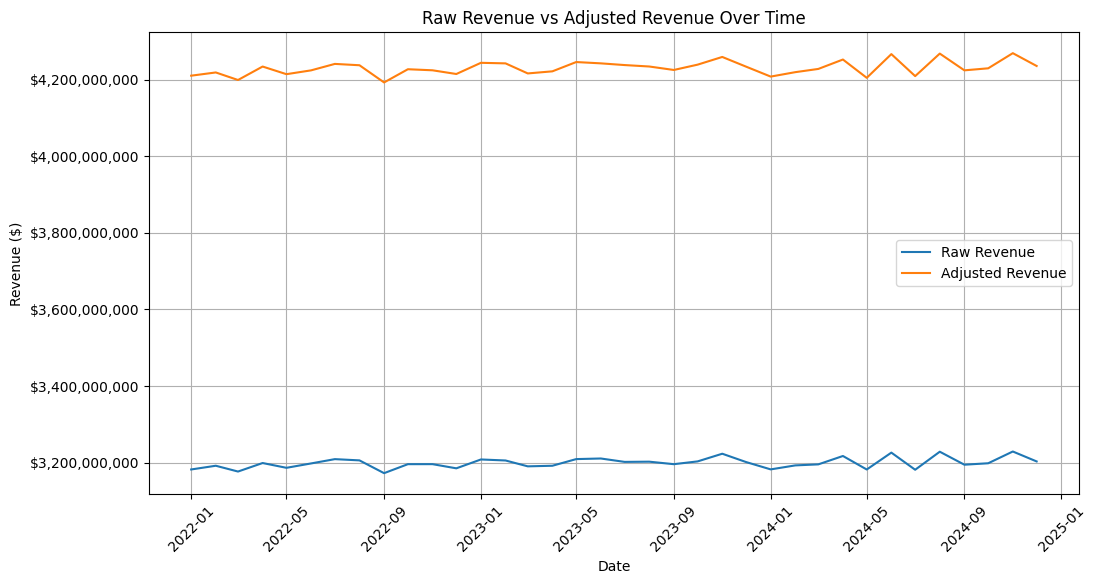

In [92]:
financials['month'] = financials['date'].dt.month
financials['month_txt'] = financials['date'].dt.month_name()

df_years = financials.groupby("date")[["revenue", "adjusted_revenue"]].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_years, x="date", y="revenue", label="Raw Revenue")
sns.lineplot(data=df_years, x="date", y="adjusted_revenue", label="Adjusted Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.title("Raw Revenue vs Adjusted Revenue Over Time")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


We also can see that the size of the business doesn't have huge impact on both raw and ajusted revenue. 

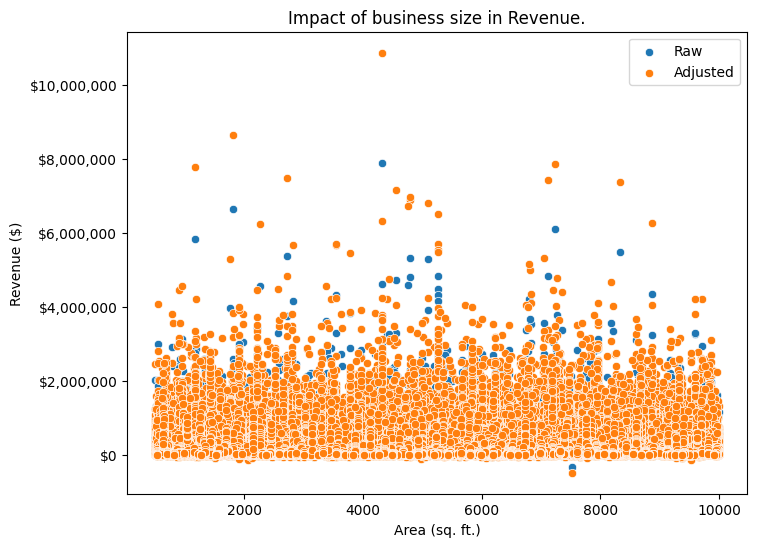

In [93]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=financials["area_sq_ft"], y=financials["revenue"], label='Raw')
sns.scatterplot(x=financials["area_sq_ft"], y=financials["adjusted_revenue"], label='Adjusted')
plt.xlabel("Area (sq. ft.)")
plt.ylabel("Revenue ($)")
plt.legend()
plt.title("Impact of business size in Revenue.")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.show()

Below are a variation of the Raw Revenue over the years, it is possible see that we had a huge jump in March 2022, we can suspect on easter as a probably cause, even seeing that in others years, March had a jump but no so expressive as 2022.

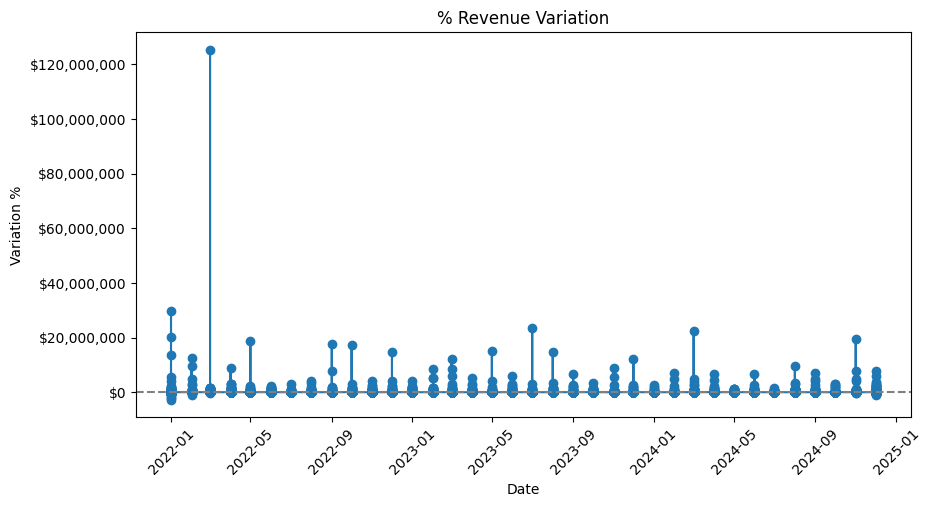

In [94]:
df = financials.copy()
df = df.sort_values("date")
df["revenue_pct_change"] = df["revenue"].pct_change() * 100
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["revenue_pct_change"], marker="o", linestyle="-")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Variation %")
plt.title("% Revenue Variation")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

Below we have 2 comparisons, the first one is regard the top 10 business in Revenue considering the Raw data, below we can find the same top 10 but based on the Adjusted Revenue.

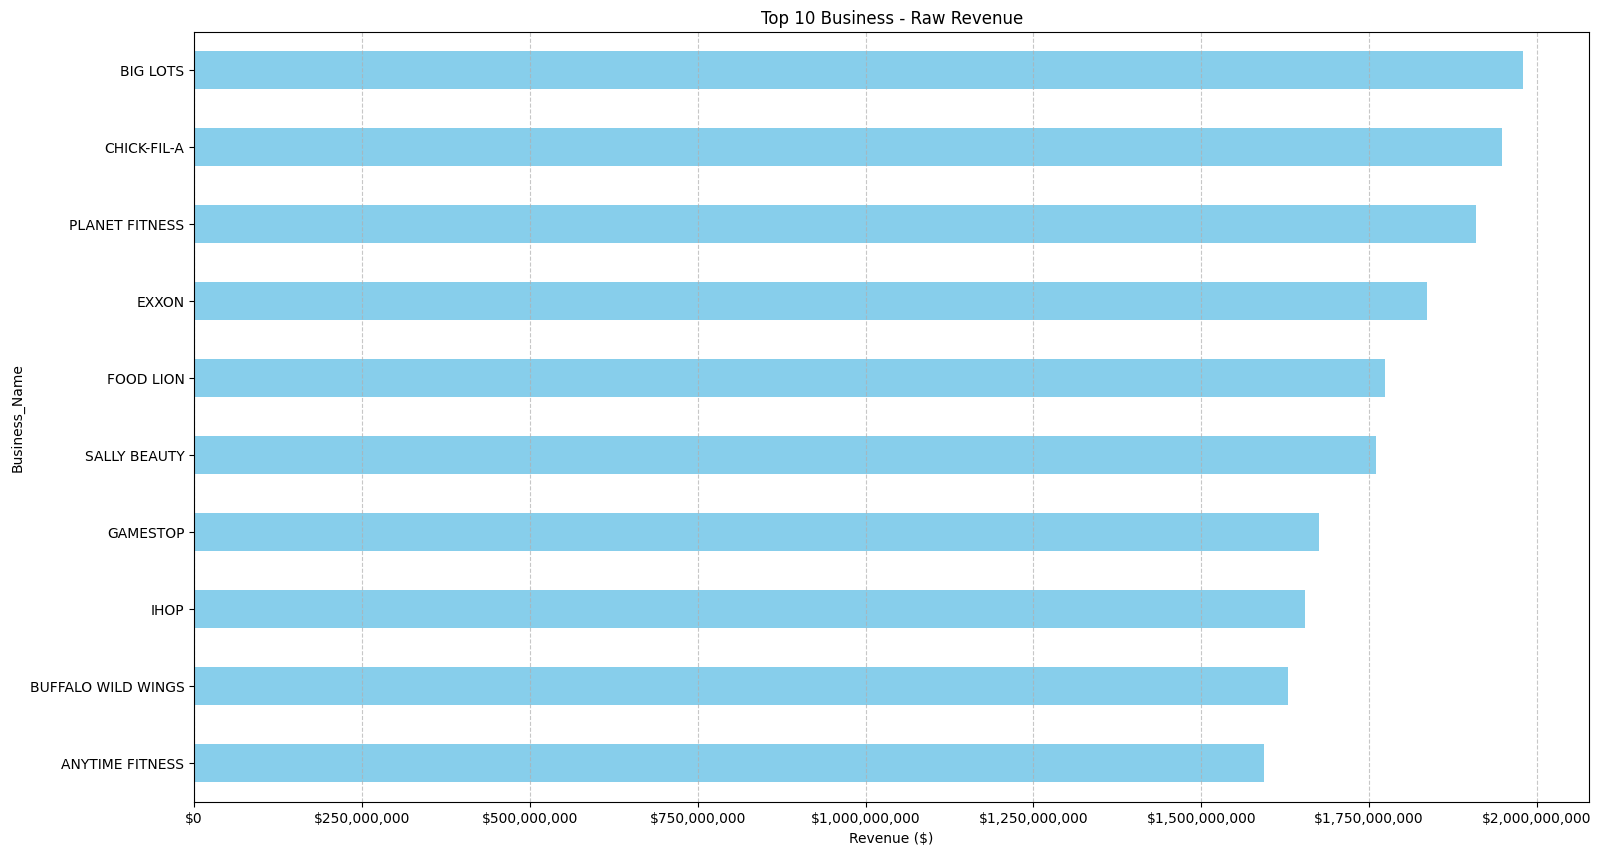

In [95]:
plt.figure(figsize=(18, 10))
df_grouped = financials.groupby("business_name")["revenue"].sum().sort_values(ascending=False).head(10)
df_grouped[::-1].plot(kind="barh", color="skyblue")
plt.xlabel("Revenue ($)")
plt.ylabel("Business_Name")
plt.title("Top 10 Business - Raw Revenue")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.show()

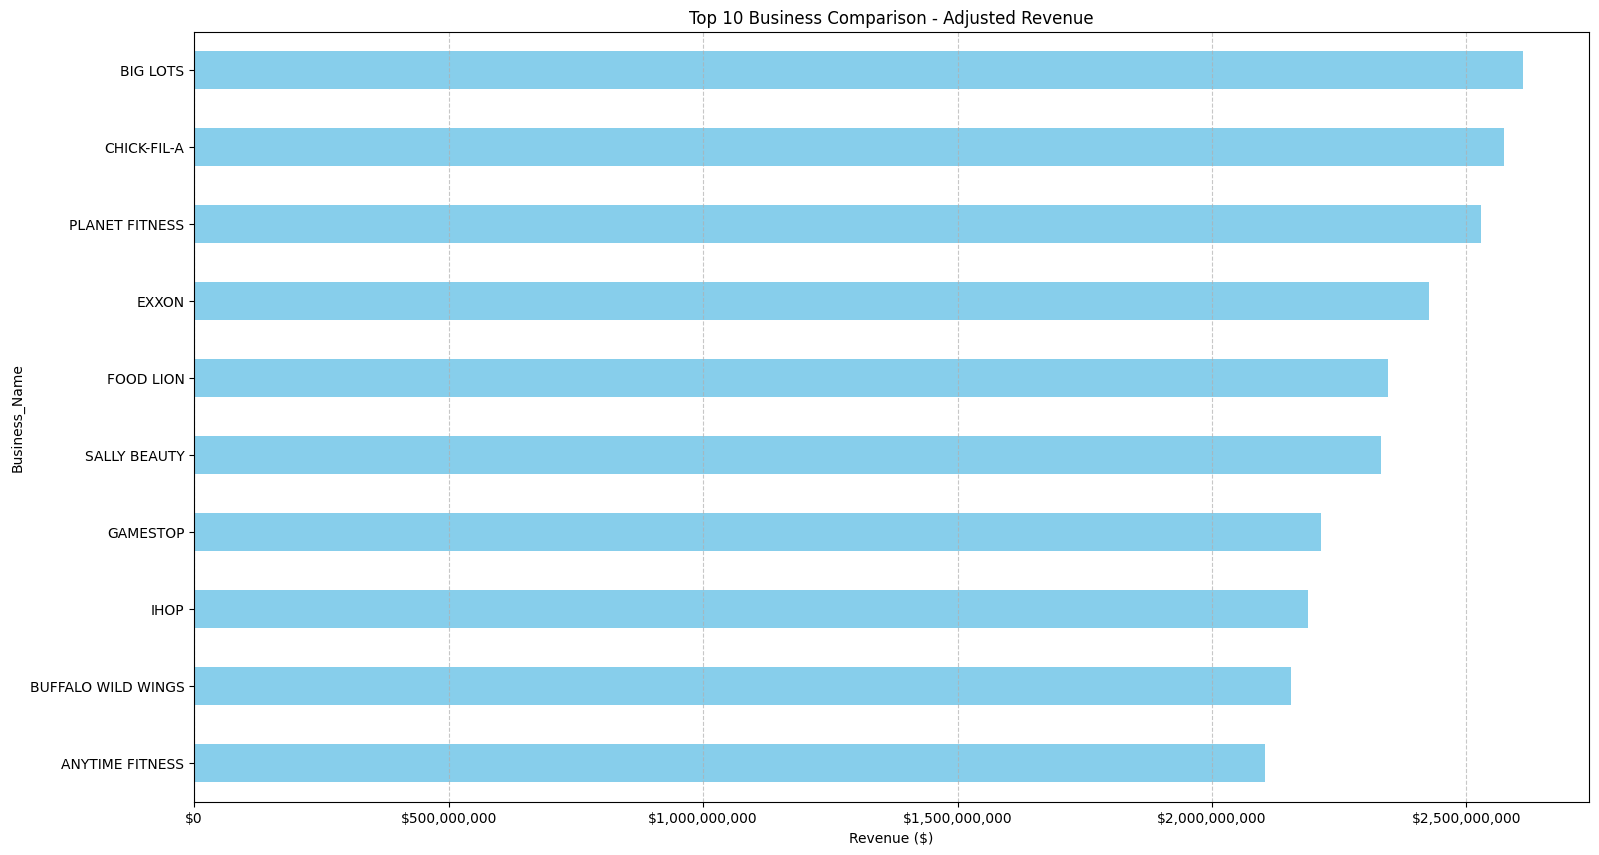

In [96]:
plt.figure(figsize=(18, 10))
df_grouped = financials.groupby("business_name")["adjusted_revenue"].sum().sort_values(ascending=False).head(10)
df_grouped[::-1].plot(kind="barh", color="skyblue")
plt.xlabel("Revenue ($)")
plt.ylabel("Business_Name")
plt.title("Top 10 Business Comparison - Adjusted Revenue")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.show()

__Theoretical Considerations__

1 - *Statistical Validation*

-- How would you calculate the minimum sample size needed to statistically validate your matching and revenue adjustment approach?

-- What parameters would this calculation depend on?"

To determine the minimum sample size needed for validation, we would use a sample size formula and the following parameters could be used.

__Confidence Level (from 0 to 1)__ - Respect to the probability that the true populaton parameter lies within the confidence interval, indicating the reliability os the estimation.

__Margin of error__ - Indicates how close we want the sample estimate to be to the true value

__Standard deviation of revenues__ - Measures the variation between raw and adjusted revenues.

__Total number of stores__ - Helps determine if an adjustment for small population is needed.



__Model Comparison__

If comparing multiple revenue adjustment models:

--What metrics would you use to evaluate superiority?

--How would you ensure comparison validity?"

To evaluate different revenue adjustment models, we would compare metrics such as:

__Mean Absolute Error (MAE)__ - Measures the average deviation between adjusted and actual revenue.

__Mean Squared Error (MSE)__ - Penalizes larger errors, making it useful for identifying more stable models.

__R² (Coefficient of Determination__ - Indicates how well the model explains the variance in actual revenue.

Some steps to ensure a fair comparison could be:

Use cross-validation to test model performance on different subsets of data.

Check if the model performs consistently across states, months, and store sizes.

Analyze the distribution of errors to ensure that adjustments don’t systematically favor certain types of stores.

__Thank You!__